In [128]:
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.cluster import contingency_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

### Задача № 1
Обучить любую модель классификации на датасете IRIS до применения PCA (2 компоненты) и после него. Сравнить качество классификации по отложенной выборке.

In [129]:
# Загрузим игрушечный датасет из sklearn
iris = datasets.load_iris()
X = iris.data
y = iris.target
X.shape, y.shape

((150, 4), (150,))

In [130]:
def standard_scale(x):
    res = (x - x.mean(axis=0)) / x.std(axis=0)
    return res

In [131]:
X = X.astype(float)
X = standard_scale(X)
X.shape

(150, 4)

In [139]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [140]:
X_train.shape, X_test.shape

((75, 4), (75, 4))

In [166]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

tree = DecisionTreeClassifier()

tree.fit(X_train, y_train)


y_pred = tree.predict(X_test)

err_mse = mean_squared_error(y_test, y_pred)
err_mse

0.06666666666666667

#### Метод PCA

In [104]:
X = iris.data
X.shape

(150, 4)

In [105]:
# масштабируем выборку
X = X.astype(float)

X = standard_scale(X)


In [107]:
X[:7]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ],
       [-0.53717756,  1.93979142, -1.16971425, -1.05217993],
       [-1.50652052,  0.78880759, -1.34022653, -1.18381211]])

In [108]:
# Найдем собственные векторы и собственные значения
 
covariance_matrix = X.T @ X

eig_values, eig_vectors = np.linalg.eig(covariance_matrix)

# сформируем список кортежей (собственное значение, собственный вектор)
eig_pairs = [(np.abs(eig_values[i]), eig_vectors[:, i]) for i in range(len(eig_values))]

# и отсортируем список по убыванию собственных значений
eig_pairs.sort(key=lambda x: x[0], reverse=True)

print('Собственные значения и собственные векторы в порядке убывания:')
for i in eig_pairs:
    print(i)

Собственные значения и собственные векторы в порядке убывания:
(437.77467247979934, array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654]))
(137.10457072021043, array([-0.37741762, -0.92329566, -0.02449161, -0.06694199]))
(22.01353133569724, array([-0.71956635,  0.24438178,  0.14212637,  0.63427274]))
(3.107225464292861, array([ 0.26128628, -0.12350962, -0.80144925,  0.52359713]))


In [109]:
# оценка доли дисперсии
eig_sum = sum(eig_values)
var_exp = [(i / eig_sum) * 100 for i in sorted(eig_values, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print(f'Доля дисперсии, описываемая каждой из компонент \n{var_exp}')

# а теперь оценим кумулятивную (то есть накапливаемую) дисперсию при учитывании каждой из компонент
print(f'Кумулятивная доля дисперсии по компонентам \n{cum_var_exp}')

Доля дисперсии, описываемая каждой из компонент 
[72.9624454132999, 22.850761786701742, 3.6689218892828745, 0.517870910715477]
Кумулятивная доля дисперсии по компонентам 
[ 72.96244541  95.8132072   99.48212909 100.        ]


Видно что первые две фичи имет почти 94% веса. Оставим только их.

In [110]:
W = np.hstack([eig_pairs[i][1].reshape(4,1) for i in range(2)])

print(f'Матрица весов W:\n', W)

Матрица весов W:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


In [112]:
# Сформируем новую матрицу "объекты-признаки"
Z = X.dot(W)
Z[:10]  # новая матрица признаков

array([[-2.26470281, -0.4800266 ],
       [-2.08096115,  0.67413356],
       [-2.36422905,  0.34190802],
       [-2.29938422,  0.59739451],
       [-2.38984217, -0.64683538],
       [-2.07563095, -1.48917752],
       [-2.44402884, -0.0476442 ],
       [-2.23284716, -0.22314807],
       [-2.33464048,  1.11532768],
       [-2.18432817,  0.46901356]])

In [146]:
Z_train, Z_test, y_train, y_test = train_test_split(Z, y, test_size=0.5, random_state=42)

In [147]:
Z_train.shape, Z_test.shape

((75, 2), (75, 2))

In [159]:
treeZ = DecisionTreeClassifier()

treeZ.fit(Z_train, y_train)


y_pred = treeZ.predict(Z_test)

err_mse = mean_squared_error(y_test, y_pred)
err_mse

0.06666666666666667

Результат сравнения по mse показывает нам, что качество моделей одинакове, при этом в случае с PCA мы использовали всего 2 признака, вместо 4 в первом случае.

### Задача № 2
Написать свою реализацию метода главных компонент с помощью сингулярного разложения с использованием функции numpy.linalg.svd()

In [210]:
X = iris.data
X = standard_scale(X)

In [216]:
# используем np.svd для получения собственных векторов
u, sigma, vh = np.linalg.svd(X, full_matrices=False, compute_uv=True)

print(f'Матрица собвственных векторов:\n {vh}')

# используем опять же первые 2 признака

W = np.hstack((vh[0].reshape(4,1), vh[1].reshape(4,1)))

print(f'Новые веса:\n {proj_matrix}')

X_new = X.dot(W)
    

Матрица собвственных векторов:
 [[ 0.52106591 -0.26934744  0.5804131   0.56485654]
 [-0.37741762 -0.92329566 -0.02449161 -0.06694199]
 [ 0.71956635 -0.24438178 -0.14212637 -0.63427274]
 [ 0.26128628 -0.12350962 -0.80144925  0.52359713]]
Новые веса:
 [[ 0.52106591 -0.37741762]
 [-0.26934744 -0.92329566]
 [ 0.5804131  -0.02449161]
 [ 0.56485654 -0.06694199]]


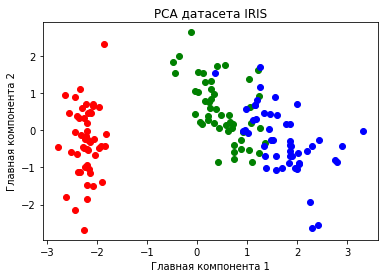

In [217]:
plt.figure()
y = iris.target
for c, i in zip("rgb", [0, 1, 2]):
    plt.scatter(X_new[y == i, 0], X_new[y == i, 1], c=c)
plt.xlabel('Главная компонента 1')
plt.ylabel('Главная компонента 2')
plt.title('PCA датасета IRIS')
plt.show()

получаем такой же результат